# Code Modularization

## Packages

In [1]:
%%capture

!pip install snowflake-connector-python
!pip install snowflake-sqlalchemy
!pip install category_encoders
!pip install hyperopt
!pip install imblearn
!pip install xgboost==1.7.4
!pip install pandas --upgrade

In [2]:
# Import necessary libraries
import sys
import os

## Original Directory

In [3]:
# Get the current original directory
original_directory = os.getcwd()

# Print curent directory
print("Original working directory: {0}".format(os.getcwd()))

Original working directory: /home/ec2-user/SageMaker


## Write Modules

### Data Loading

In [4]:
%%writefile ./src/data_loader.py

import pandas as pd
import sqlalchemy
import snowflake.connector
from sqlalchemy import create_engine
from snowflake.sqlalchemy import *
import snowflake_creds as snowflake_creds
from sklearn.model_selection import train_test_split

def load_data_and_create_simulated_set(stratify_colname='NO_SHOW', test_size=0.2, random_state=42):
    """
    Connects to Snowflake, retrieves data, and creates a stratified simulated set.
    
    :param snowflake_creds: A credentials object with USER_NAME and PASSWORD attributes.
    :param stratify_colname: The name of the column to stratify by.
    :param test_size: The proportion of the dataset to include in the simulated set.
    :param random_state: The seed used by the random number generator.
    :return: A tuple containing the full dataset and the simulated set.
    """
    
    # Define the Snowflake connection parameters
    engine = create_engine(URL(
            account="lvb79593.us-east-1",
            user=snowflake_creds.USER_NAME,
            password=snowflake_creds.PASSWORD,
            role="ACCOUNTADMIN",
            warehouse="MY_WAREHOUSE",
            database="MEDICAL_APPOINTMENT_NO_SHOW",
            schema="APPOINTMENT_SCHEMA"
        ))

    # Define the SQL query that retrieves the appointment data
    query = """
    SELECT * FROM MEDICAL_APPOINTMENT_NO_SHOW.APPOINTMENT_SCHEMA.APPOINTMENT_DATA;
    """

    # Use a context manager to ensure the connection is closed after executing the query
    try:
        with engine.connect() as conn:
            # Execute the query and load the result into a Pandas DataFrame
            data = pd.read_sql(query, conn)
            # Convert column names to uppercase
            data.columns = [col.upper() for col in data.columns.tolist()]
            # Print connection successful message
            print("Connection successful. Data loaded into DataFrame.")
            
    except Exception as e:  # Catch any exceptions that occur
        print(f"An error occurred: {e}")
        return None, None

    # Save the data frame to our local disk
    data.to_pickle("../data/input/full_data.pkl")

    # Create a stratified simulated set
    _, simulated_set = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
        stratify=data[stratify_colname] if stratify_colname in data.columns else None
    )
    
    # Set the target column in the simulated set to empty values
    if stratify_colname in simulated_set.columns:
        simulated_set[stratify_colname] = ''

    # Save the simulated set to a CSV file
    simulated_set.to_csv('../data/input/simulated_set.csv', index=False)
    
    return data, simulated_set

def load_local_data(full_data_path="../data/input/full_data.pkl", simulated_data_path="../data/input/simulated_set.csv"):
    """
    Loads the full dataset and simulated set from local disk.
    
    :param full_data_path: The path to the full data pickle file.
    :param simulated_data_path: The path to the simulated set CSV file.
    :return: A tuple containing the full dataset and the simulated set.
    """
    try:
        # Load the full dataset from a pickle file
        full_data = pd.read_pickle(full_data_path)
        
        # Load the simulated set from a CSV file
        simulated_set = pd.read_csv(simulated_data_path, parse_dates=['SCHEDULEDDAY', 'APPOINTMENTDAY'])
        
        return full_data, simulated_set
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None, None

Overwriting ./src/data_loader.py


### Preprocessing

In [5]:
%%writefile ./src/preprocessing.py

import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

def preprocess_data(data, is_simulated=False):
    """
    Preprocesses the medical appointment data.
    
    :param data: The DataFrame containing the medical appointment data.
    :param is_simulated: A boolean flag indicating whether the data is a simulated set with NaN target values.
    :return: The preprocessed DataFrame.
    """
    # Drop 'PATIENTID' column
    data = data.drop('PATIENTID', axis=1)
    
    # Set 'APPOINTMENTID' as index
    data = data.set_index('APPOINTMENTID')
    
    # Map 'NO_SHOW' to 0 and 1 only if it's not a simulated set
    if not is_simulated:
        data['NO_SHOW'] = data['NO_SHOW'].map({'No': 0, 'Yes': 1})
    
    # Ensure the difference between 'APPOINTMENTDAY' and 'SCHEDULEDDAY' is non-negative
    data = data[(data['APPOINTMENTDAY'] - data['SCHEDULEDDAY']).dt.days + 1 >= 0]
    
    # Ensure 'AGE' is non-negative
    data = data[data['AGE'] >= 0]
    
    return data

def split_data(data, target_col='NO_SHOW', test_size=0.2, random_state=42):
    """
    Splits the data into training and test sets without separating X and y.
    
    :param data: The DataFrame to split.
    :param target_col: The name of the target column.
    :param test_size: The proportion of the dataset to include in the test split.
    :param random_state: The seed used by the random number generator.
    :return: A tuple containing the training set and test set.
    """
    return train_test_split(
        data, test_size=test_size, random_state=random_state, stratify=data[target_col]
    )

def encode_gender(data):
    """
    Encodes the 'GENDER' column in the dataset, mapping 'M' to 1 and 'F' to 0.

    :param data: Pandas DataFrame to be processed.
    :return: DataFrame with the encoded 'GENDER' column.
    """
    gender_mapping = {'M': 1, 'F': 0}
    data['GENDER'] = data['GENDER'].map(gender_mapping)
    return data

def one_hot_encode_gender_age(data):
    """
    One-hot encodes the 'GENDER_AGE' column in the dataset.

    :param data: Pandas DataFrame to be processed.
    :return: DataFrame with one-hot encoded 'GENDER_AGE' column.
    """
    data = pd.get_dummies(data, columns=['GENDER_AGE'], drop_first=True, dtype=int)

    # Reorder columns to make 'NO_SHOW' the last column, if it exists
    if 'NO_SHOW' in data.columns:
        cols = list(data.columns)
        cols.remove('NO_SHOW')
        cols.append('NO_SHOW')
        data = data[cols]

    return data

def target_encode_neighbourhood(train_data, test_data):
    """
    Target encodes the 'NEIGHBOURHOOD' column in the training and testing datasets.

    :param train_data: Training dataset as a Pandas DataFrame.
    :param test_data: Testing dataset as a Pandas DataFrame.
    :return: Tuple of DataFrames with target encoded 'NEIGHBOURHOOD' column.
    """
    encoder = TargetEncoder()

    # Fit and transform on the training data
    train_data['NEIGHBOURHOOD'] = encoder.fit_transform(train_data['NEIGHBOURHOOD'], train_data['NO_SHOW'])

    # Transform on the testing data
    test_data['NEIGHBOURHOOD'] = encoder.transform(test_data['NEIGHBOURHOOD'])

    return train_data, test_data

def apply_scaling(train_set, test_set):
    """
    Applies scaling to the feature columns of the train and test sets.
    
    :param train_set: The training set DataFrame.
    :param test_set: The test set DataFrame.
    :return: Scaled versions of the train and test sets.
    """
    # Initialize the scaler
    scaler = StandardScaler()

    # List of feature columns to scale, excluding the target column 'NO_SHOW'
    feature_cols = train_set.columns.difference(['NO_SHOW'])

    # Create copies of the original data
    train_set_scaled = train_set.copy()
    test_set_scaled = test_set.copy()

    # Apply scaling to the feature columns in the training and test sets
    train_set_scaled[feature_cols] = scaler.fit_transform(train_set[feature_cols])
    test_set_scaled[feature_cols] = scaler.transform(test_set[feature_cols])

    return train_set_scaled, test_set_scaled

Overwriting ./src/preprocessing.py


### Feature Engineering

In [6]:
%%writefile ./src/feature_engineering.py

import pandas as pd
import numpy as np

def create_age_gender_feature(data):
    """
    Creates a combined feature of gender and bucketized age in the given dataset.
    
    :param data: The DataFrame to process.
    :return: The DataFrame with the new combined feature.
    """
    bins = [0, 13, 18, 31, 51, np.inf]
    labels = ['0-12', '13-17', '18-30', '31-50', '50+']

    # Create AGE_BUCKET and then create GENDER_AGE
    data['AGE_BUCKET'] = pd.cut(data['AGE'], bins=bins, labels=labels, right=False)
    data['GENDER_AGE'] = data['GENDER'] + '_' + data['AGE_BUCKET'].astype(str)

    # Drop the AGE_BUCKET column
    data.drop('AGE_BUCKET', axis=1, inplace=True)
    
    # Reorder columns to make 'NO_SHOW' the last column, if it exists
    if 'NO_SHOW' in data.columns:
        cols = list(data.columns)
        cols.remove('NO_SHOW')
        cols.append('NO_SHOW')
        data = data[cols]

    return data

def calculate_days_till_appointment(data):
    """
    Adds a feature representing the number of days till the appointment.

    :param data: Pandas DataFrame to be processed.
    :return: DataFrame with the new feature added.
    """
    # Calculate the number of days till the appointment
    data['DAYS_TILL_APPOINTMENT'] = (data['APPOINTMENTDAY'] - data['SCHEDULEDDAY']).dt.days + 1

    # If 'NO_SHOW' is a column, reorder columns to make it the last column
    if 'NO_SHOW' in data.columns:
        cols = list(data.columns)
        cols.remove('NO_SHOW')
        cols.append('NO_SHOW')
        data = data[cols]

    return data

def extract_datetime_features(data):
    """
    Extracts year, month, and day from 'SCHEDULEDDAY' and 'APPOINTMENTDAY' and adds them as new features.

    :param data: Pandas DataFrame to be processed.
    :return: DataFrame with new datetime features.
    """
    # Extracting year, month, and day from SCHEDULEDDAY
    data['SCHEDULEDDAY_YEAR'] = data['SCHEDULEDDAY'].dt.year
    data['SCHEDULEDDAY_MONTH'] = data['SCHEDULEDDAY'].dt.month
    data['SCHEDULEDDAY_DAY'] = data['SCHEDULEDDAY'].dt.day

    # Extracting year, month, and day from APPOINTMENTDAY
    data['APPOINTMENTDAY_YEAR'] = data['APPOINTMENTDAY'].dt.year
    data['APPOINTMENTDAY_MONTH'] = data['APPOINTMENTDAY'].dt.month
    data['APPOINTMENTDAY_DAY'] = data['APPOINTMENTDAY'].dt.day

    # Dropping the original datetime columns
    data.drop(['SCHEDULEDDAY', 'APPOINTMENTDAY'], axis=1, inplace=True)
    
    # Columns to check for unique values
    year_columns_to_check = ['SCHEDULEDDAY_YEAR', 'APPOINTMENTDAY_YEAR']

    # Check and drop year columns with only one unique value
    for col in year_columns_to_check:
        if data[col].nunique() == 1:
            #print(f"Dropping {col} as it has only one unique value.")
            data.drop([col], axis=1, inplace=True)

    # If 'NO_SHOW' is a column, reorder columns to make it the last column
    if 'NO_SHOW' in data.columns:
        cols = list(data.columns)
        cols.remove('NO_SHOW')
        cols.append('NO_SHOW')
        data = data[cols]

    return data

Overwriting ./src/feature_engineering.py


### Modeling

In [7]:
%%writefile ./src/modeling.py

import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def select_and_save_important_features(train_data, target_column='NO_SHOW', output_path='../data/features/combined_important_features.pkl'):
    """
    Selects important features based on Logistic Regression and Decision Tree models and saves them to a file.
    
    :param train_data: The training dataset.
    :param target_column: The name of the target column.
    :param output_path: The path to save the important features.
    """
    # Prepare the data
    X = train_data.drop(target_column, axis=1)
    y = train_data[target_column]

    # Initialize and fit the Logistic Regression model
    logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
    logistic_model.fit(X, y)

    # Get coefficients and filter important features
    logistic_coef = pd.DataFrame(logistic_model.coef_.reshape(-1, 1), index=X.columns, columns=['Coefficient'])
    important_features_logistic = logistic_coef[abs(logistic_coef['Coefficient']) >= 0.01].index.values.tolist()

    # Initialize and fit the Decision Tree model
    decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    decision_tree_model.fit(X, y)

    # Get feature importances and filter important features
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': decision_tree_model.feature_importances_})
    feature_importances = feature_importances.sort_values('Importance', ascending=False)
    important_features_tree = feature_importances[feature_importances['Importance'] >= 0.01]['Feature'].values.tolist()

    # Combine the important features from both models
    combined_important_features_union = list(set(important_features_logistic) | set(important_features_tree))

    # Save the combined important features to a file
    with open(output_path, 'wb') as f:
        pickle.dump(combined_important_features_union, f)

    print(f"Important features saved to {output_path}")

def filter_data_with_important_features(data, important_features_path='../data/features/X_train_important_features.pkl', target_column='NO_SHOW'):
    """
    Filters the given dataset with important features, adds missing features with default values, 
    and separates the target variable.
    
    :param data: The dataset to be filtered.
    :param important_features_path: The path to the pickle file containing important features.
    :param target_column: The name of the target column.
    :return: A tuple containing the filtered features (X) and the target variable (Y).
    """
    # Load the important features from the pickle file
    with open(important_features_path, 'rb') as f:
        important_features = pickle.load(f)

    # Initialize a DataFrame with zeros for all important features
    X_filtered = pd.DataFrame(0, index=data.index, columns=important_features)

    # Update the DataFrame with the data from the original dataset
    # Ensure to exclude the target column
    X_filtered.update(data[important_features])

    # Extract the target variable if it exists in the dataset
    Y = data[target_column] if target_column in data.columns else None

    return X_filtered, Y

def tune_hyperparameters(X_train, y_train, max_evals=100):
    """
    Tune hyperparameters for the XGBoost model using Hyperopt.

    :param X_train: Training features.
    :param y_train: Training labels.
    :param max_evals: The maximum number of evaluations during optimization.
    :return: A dictionary containing the best hyperparameters.
    """
    best_score = 0  # Initialize the best score
    iteration = 0  # Initialize the iteration counter

    # Define the objective function
    def objective(params):
        nonlocal best_score  # Use nonlocal to refer to the outer scope's best_score
        nonlocal iteration  # Use nonlocal to refer to the outer scope's iteration
        iteration += 1  # Increment the iteration counter
        
        clf = XGBClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            gamma=params['gamma'],
            colsample_bytree=params['colsample_bytree'],
            subsample=params['subsample'],
            min_child_weight=int(params['min_child_weight']),
            scale_pos_weight=(0.798 / 0.202),
            random_state=42
        )
        
        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
        
        if score > best_score:
            best_score = score
            print(f"New best score at iteration {iteration}: {best_score}")
            display("Best parameters so far:", params)
        
        return {'loss': -score, 'status': STATUS_OK}

    # Define the parameter space
    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
        'max_depth': hp.quniform('max_depth', 3, 14, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
        'subsample': hp.uniform('subsample', 0.6, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
    }

    # Initialize a trials object
    trials = Trials()

    # Run the hyperparameter optimization
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    # Save the best hyperparameters to a pickle file
    with open('../data/hyperparameters/XGBoost_hyperparameters.pkl', 'wb') as f:
        pickle.dump(best, f)

    print("Best hyperparameters saved to '../data/hyperparameters/XGBoost_hyperparameters.pkl'")
    
def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test, hyperparameters_path='../data/hyperparameters/XGBoost_hyperparameters.pkl'):
    """
    Train and evaluate an XGBoost model using the best hyperparameters.

    :param X_train: Training features.
    :param y_train: Training labels.
    :param X_test: Testing features.
    :param y_test: Testing labels.
    :param hyperparameters_path: Path to the pickle file containing the best hyperparameters.
    """
    # Load the best hyperparameters
    with open(hyperparameters_path, 'rb') as f:
        best_params = pickle.load(f)

    # Convert float values to int for certain parameters
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_child_weight'] = int(best_params['min_child_weight'])
    best_params['scale_pos_weight'] = 0.798 / 0.202
    best_params['random_state'] = 42

    # Initialize the XGBoost model
    xgb_model_final = XGBClassifier(**best_params)

    # Fit the model on the filtered training set
    xgb_model_final.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_final = xgb_model_final.predict(X_test)
    y_pred_prob = xgb_model_final.predict_proba(X_test)[:, 1]

    # Evaluate the model
    roc_auc_final = roc_auc_score(y_test, y_pred_prob)
    f1_score_final = f1_score(y_test, y_pred_final)

    print(f"Final Model Evaluation:")
    print(f"ROC AUC: {roc_auc_final}")
    print(f"F1 Score: {f1_score_final}")
    
    # Save the trained model to a pickle file
    with open('../model/xgb_model.pkl', 'wb') as model_file:
        pickle.dump(xgb_model_final, model_file)

    print("Model saved to '../model/xgb_model.pkl'")

def load_model_and_predict(X_simulated, model_path='../model/xgb_model.pkl', output_path='../data/output/predictions_with_features.csv'):
    """
    Loads a trained model, makes predictions on the provided dataset, and saves the predictions along with features.

    :param X_simulated: The dataset to make predictions on.
    :param model_path: Path to the trained model file.
    :param output_path: Path to save the predictions with features.
    :return: None
    """
    # Load the trained model
    with open(model_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # Make predictions
    predictions = model.predict(X_simulated)

    # Reset index to bring 'APPOINTMENTID' back as a column
    X_simulated_reset = X_simulated.reset_index()

    # Combine predictions with features
    predictions_df = X_simulated_reset.copy()
    predictions_df['PREDICTED_NO_SHOW'] = predictions

    # Save the combined DataFrame to a CSV file
    predictions_df.to_csv(output_path, index=False)

    print(f"Predictions with features saved to {output_path}")
    
def evaluate_model(X_test_filtered, y_test, model_path="../model/xgb_model.pkl"):
    """
    Loads a trained model and performs detailed evaluation on the test set.

    :param X_test_filtered: Filtered features of the test set.
    :param y_test: Target variable of the test set.
    :param model_path: Path to the trained model file.
    :return: None
    """
    # Load the trained model
    with open(model_path, "rb") as f:
        loaded_model = pickle.load(f)

    # Make predictions on the test set
    y_pred_test = loaded_model.predict(X_test_filtered)
    y_pred_prob_test = loaded_model.predict_proba(X_test_filtered)[:, 1]

    # Evaluate on Test Set
    print("Evaluation on Test Set:")
    evaluate_predictions(y_test, y_pred_test, y_pred_prob_test)

def evaluate_predictions(y_true, y_pred, y_pred_prob):
    """
    Generates and displays evaluation metrics and plots for predictions.

    :param y_true: True target values.
    :param y_pred: Predicted target values.
    :param y_pred_prob: Predicted probabilities.
    :return: None
    """
    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['No-Show', 'Show']).plot()
    plt.title('Confusion Matrix')
    plt.show()

    # Generate and print classification report
    report = classification_report(y_true, y_pred, target_names=['No-Show', 'Show'])
    print("Classification Report:")
    print(report)

    # Compute and plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Compute and plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

Overwriting ./src/modeling.py


### Model Training

In [8]:
%%writefile ./src/train.py

from data_loader import *
from preprocessing import *
from feature_engineering import *
from modeling import *

def main():
    # Load full data
    full_data, _ = load_local_data()

    # Preprocessing
    preprocessed_full_data = preprocess_data(full_data, is_simulated=False)

    # Train test split
    train_set, test_set = split_data(preprocessed_full_data)

    # Create 'GENDER_AGE' feature
    train_set = create_age_gender_feature(train_set)
    test_set = create_age_gender_feature(test_set)

    # Create 'DAYS_TILL_APPOINTMENT' feature
    train_set = calculate_days_till_appointment(train_set)
    test_set = calculate_days_till_appointment(test_set)

    # Extract the year, month, and day from the 'SCHEDULEDDAY' and 'APPOINTMENTDAY' 
    train_set = extract_datetime_features(train_set)
    test_set = extract_datetime_features(test_set)

    # Map the 'GENDER'
    train_set = encode_gender(train_set)
    test_set = encode_gender(test_set)

    # One-hot encode 'GENDER_AGE'
    train_set = one_hot_encode_gender_age(train_set)
    train_set.to_csv('../data/processed/one_hot_encoded_train_set.csv', index=False)
    test_set = one_hot_encode_gender_age(test_set)

    # Target encode 'NEIGHBOURHOOD'
    train_set, test_set = target_encode_neighbourhood(train_set, test_set)

    # Filter and split train set to X and y
    X_train_filtered, y_train = filter_data_with_important_features(train_set)
    X_test_filtered, y_test = filter_data_with_important_features(test_set)

    # Train and evaluate an XGBoost model
    train_and_evaluate_xgboost(X_train_filtered, y_train, X_test_filtered, y_test)

    # Loads a trained model and performs detailed evaluation
    evaluate_model(X_test_filtered, y_test)

if __name__ == "__main__":
    main()

Overwriting ./src/train.py


### Model Prediction

In [9]:
%%writefile ./src/predict.py

from data_loader import *
from preprocessing import *
from feature_engineering import *
from modeling import *

def main():
    # Load simulated data
    _, simulated_data = load_local_data()

    # Preprocessing
    preprocessed_simulated_set = preprocess_data(simulated_data, is_simulated=True)

    # Create 'GENDER_AGE' feature
    preprocessed_simulated_set = create_age_gender_feature(preprocessed_simulated_set)

    # Create 'DAYS_TILL_APPOINTMENT' feature 
    preprocessed_simulated_set = calculate_days_till_appointment(preprocessed_simulated_set)

    # Extract the year, month, and day from the 'SCHEDULEDDAY' and 'APPOINTMENTDAY'
    preprocessed_simulated_set = extract_datetime_features(preprocessed_simulated_set)

    # Map the 'GENDER'
    preprocessed_simulated_set = encode_gender(preprocessed_simulated_set)

    # One-hot encode 'GENDER_AGE'
    preprocessed_simulated_set = one_hot_encode_gender_age(preprocessed_simulated_set)

    # Target encode 'NEIGHBOURHOOD'
    one_hot_encoded_train_set = pd.read_csv('../data/processed/one_hot_encoded_train_set.csv')
    _, preprocessed_simulated_set = target_encode_neighbourhood(one_hot_encoded_train_set, preprocessed_simulated_set)

    # Filter simulate set
    X_simulated_filtered, _ = filter_data_with_important_features(preprocessed_simulated_set)

    # Loads a trained model and makes predictions
    load_model_and_predict(X_simulated_filtered)

if __name__ == "__main__":
    main()

Overwriting ./src/predict.py


## Change Directory

In [10]:
# Change the current working directory to './src'
os.chdir('./src')

# Verify the change
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/ec2-user/SageMaker/src


## Run train.py

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/SageMaker/src/modeling.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16845329 0.15936255 0.22066327 ... 0.15306122 0.20429059 0.23984273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_filtered.update(data[important_features])
/home/ec2-user/SageMaker/src/modeling.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19438151 0.1849711  0.2011768  ... 0.19982847 0.1544586  0.23767798]' has dtype incompatible with int64, please explicitly c

Final Model Evaluation:
ROC AUC: 0.7364460454464645
F1 Score: 0.44980247922626354
Model saved to '../model/xgb_model.pkl'
Evaluation on Test Set:


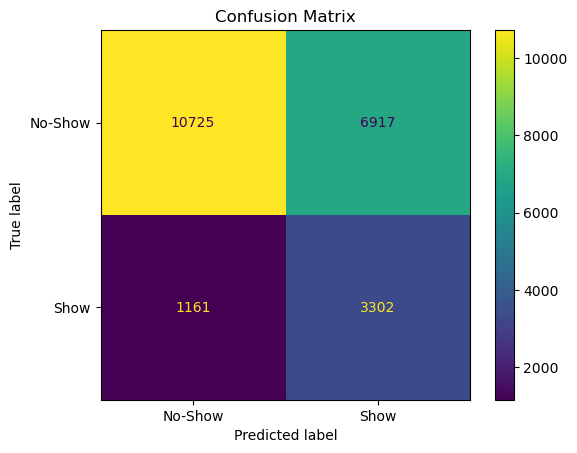

Classification Report:
              precision    recall  f1-score   support

     No-Show       0.90      0.61      0.73     17642
        Show       0.32      0.74      0.45      4463

    accuracy                           0.63     22105
   macro avg       0.61      0.67      0.59     22105
weighted avg       0.79      0.63      0.67     22105



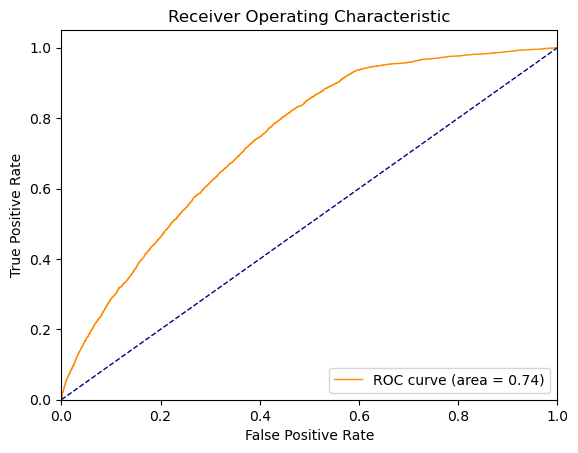

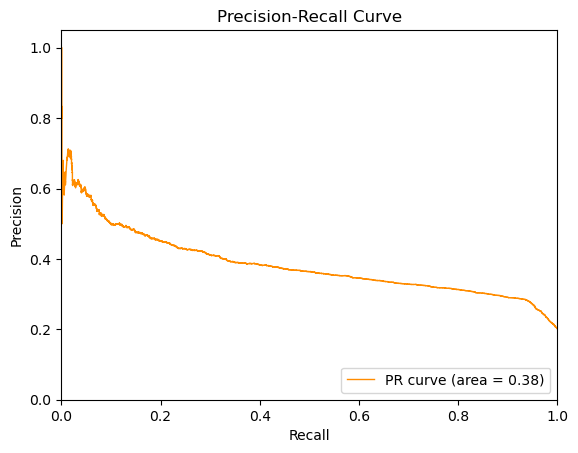

In [11]:
%run /home/ec2-user/SageMaker/src/train.py

## Run predict.py

In [12]:
%run /home/ec2-user/SageMaker/src/predict.py

/home/ec2-user/SageMaker/src/modeling.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22994129 0.15789474 0.18247881 ... 0.18247881 0.20512821 0.1590106 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_filtered.update(data[important_features])


Predictions with features saved to ../data/output/predictions_with_features.csv


## Reset Directory

In [13]:
# Reset to the original directory
os.chdir(original_directory)

# Verify the reset
print("Current working directory reset to: {0}".format(os.getcwd()))

Current working directory reset to: /home/ec2-user/SageMaker
